#### Project2: Image Processing
#### Student: Le Hoang Sang - 21127158
#### Class: 21CLC02

In [451]:
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np 
import time

Các hàm bổ trợ

In [452]:
def read_image():
    image_path = input("Enter image's name: ")
    #image_path = "lena.png"
    try:
        image = PIL.Image.open(image_path)
        height, width = image.size
        image = np.array(image)
        #image = image.reshape(-1, 3)
        return image_path, image, width, height
    except FileNotFoundError:
        print("Can not find this image")
    except:
        print("Error when open this image")

In [453]:
def is_grayscale(image):
    if len(image.shape) == 2:
        # Nếu số chiều của ảnh là 2, nghĩa là nó có một kênh màu
        return True
    elif len(image.shape) == 3 and image.shape[2] == 1:
        # Nếu ảnh có ba chiều nhưng chiều thứ ba là 1, nghĩa là nó cũng có một kênh màu
        return True
    else:
        return False

In [454]:
def display_image(image):
    if is_grayscale(image):
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
        
    plt.show()

In [455]:
def comparison_display(image_input, image_output):
    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(image_input)
    axes[0].set_title("Before")

    if is_grayscale(image_output):
        axes[1].imshow(image_output, cmap='gray')
    else:
        axes[1].imshow(image_output)
    axes[1].set_title("After")

    for ax in axes:
        ax.axis("off")
    plt.show()

In [456]:
def ask_image_format():
    while True:
        user_input = input("Choose format (pdf/png): ").lower()
        if user_input == "pdf" or user_input == "png":
            return user_input
        else:
            print("Choose valid format (pdf/png).")

In [457]:
def save_image(rgb_array, image_path, type_edit):
    image_path = image_path.split(".")[0] + "_" + type_edit + "."

    #image_format = ask_image_format() # if user need to choose image format
    image_format = "png" # set as default format

    rgb_array = np.uint8(rgb_array)
    image = PIL.Image.fromarray(rgb_array)
    image.save(image_path + image_format)

1. Thay đổi độ sáng cho ảnh

In [458]:
def change_brightness(image, brightness_level = 40):
    brightened_image = np.clip(image + np.array([brightness_level], dtype=np.int16), 0, 255).astype(np.uint8)
    return brightened_image

2. Thay đổi độ tương phản

In [459]:
def adjust_contrast(image, contrast_level = 1.4):
    contrast_level = np.clip(float(contrast_level), -255, 255)
    factor = (259 * (contrast_level + 255)) / (255 * (259 - contrast_level))
    result = np.clip(factor * (image.astype(float) - 128) + 128, 0, 255).astype(np.uint8)
    return result

3. Lật ảnh (ngang - dọc)

In [460]:
def flip(image, options = "horizontal"):
    if options == "horizontal":
        return image[:, ::-1]
    elif options == "vertical":
        return image[::-1]
    else:
        return image

4. Chuyển đổi ảnh RGB thành ảnh xám, sepia

In [461]:
def convert(image, options="gray"):
    if options == "gray":
        weight = np.array([0.3, 0.59, 0.11])
        result_image = np.dot(image[..., :3], weight).astype(np.uint8)
    elif options == "sepia":
        weight = np.array([[0.393, 0.769, 0.189],
                            [0.349, 0.686, 0.168],
                            [0.272, 0.534, 0.131]])
        new_channels = np.dot(image[..., :3], weight.T)
        new_channels = np.clip(new_channels, 0, 255)
        result_image = np.uint8(new_channels)
    else:
        print("Error option")
        return image
    return result_image

5. Làm mờ/ sắc nét ảnh

In [462]:
def custom_sharpness(image, kernel, kernel_size):
    blurred_image = np.zeros_like(image, dtype=float)
    k_center = kernel_size // 2
    padded_image = np.pad(image, ((k_center, k_center), (k_center, k_center), (0, 0)), mode='constant')

    for c in range(image.shape[-1]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                blurred_image[i, j, c] = np.sum(padded_image[i:i+kernel_size, j:j+kernel_size, c] * kernel)

    blurred_image = np.clip(blurred_image, 0, 255).astype(np.uint8)
    return blurred_image

In [463]:
def custom_sharpness_handler(image, options):
    if options == "blur":
        kernel = np.array([[1,4,6,4,1], 
                       [4,16,24,16,4],
                       [6,24,36,24,6],
                       [4,16,24,16,4],
                       [1,4,6,4,1]])
        kernel = kernel / 256
        result = custom_sharpness(image, kernel, 5)
    elif options == "sharp":
        kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
        result = custom_sharpness(image, kernel, 3)
    else:
        print("Error option")
        return image
    return result

6. Cắt ảnh theo kích thước (cắt ở trung tâm)

In [464]:
def center_cut(image, padding = 250):
    height, width, _ = image.shape
    min_size = height - padding
    
    top_left_x = (width - min_size) // 2
    top_left_y = (height - min_size) // 2
    cropped_image = image[top_left_y:top_left_y+min_size, top_left_x:top_left_x+min_size]
    
    return cropped_image

7. Cắt ảnh theo khung hình tròn

In [465]:
def rounded_cut(image):
    height, width, _ = image.shape
    center_x = width // 2
    center_y = height // 2
    radius = min(width, height) // 2
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    distances = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    mask = distances <= radius

    cropped_image = image.copy()
    cropped_image[~mask] = 0

    return cropped_image

8. Viết hàm main xử lý

In [466]:
def user_handler(image_path, image, choice):
    if choice == '0':
        total_time = 0.0
        # Recursion
        total_time += user_handler(image_path, image, "1")
        total_time += user_handler(image_path, image, "2")
        total_time += user_handler(image_path, image, "3")
        total_time += user_handler(image_path, image, "4")
        total_time += user_handler(image_path, image, "5")
        total_time += user_handler(image_path, image, "6")
        total_time += user_handler(image_path, image, "7")
        return total_time
            
    elif choice == '1':
        print("1. Thay đổi độ sáng cho ảnh")

        brightness_level = 30

        start = time.time()
        brightened_image = change_brightness(image, brightness_level)
        end = time.time()

        comparison_display(image, brightened_image)
        save_image(brightened_image, image_path, "brightened")
        return end - start
            
    elif choice == '2':
        print("2. Thay đổi độ tương phản")
        contrast_level = 50

        start = time.time()
        adjusted_image = adjust_contrast(image, contrast_level)
        end = time.time()

        comparison_display(image, adjusted_image)
        save_image(adjusted_image, image_path, "adjusted")
        return end - start

    elif choice == '3':
        print("3. Lật ảnh (ngang - dọc)")
        type = input("1 (Horizontal), 2 (Vertical)")
    
        if type == "1":
            start = time.time()
            flipped_image = flip(image, options = "horizontal")
            end = time.time()
        elif type == "2":
            start = time.time()
            flipped_image = flip(image, options = "vertical")
            end = time.time()
        else:
            print("Lựa chọn không hợp lệ. Mặc định là Horizontal")
            start = time.time()
            flipped_image = flip(image, options = "horizontal")
            end = time.time()
            
        comparison_display(image, flipped_image)
        save_image(flipped_image, image_path, "flipped")
        return end - start

    elif choice == '4':
        print("4. Chuyển đổi ảnh RGB thành ảnh xám/sepia")

        start = time.time()
        gray_img = convert(image, options = "gray")
        sepia_img = convert(image, options = "sepia")
        end = time.time()

        comparison_display(image, gray_img)
        save_image(gray_img, image_path, "gray")
        comparison_display(image, sepia_img)
        save_image(sepia_img, image_path, "sepia")
        return end - start

    elif choice == '5':
        print("5. Làm mờ/sắc nét ảnh")

        start = time.time()
        blur_img = custom_sharpness_handler(image, "blur")
        sharp_img = custom_sharpness_handler(blur_img, "sharp")
        end = time.time()

        comparison_display(image, blur_img)
        save_image(blur_img, image_path, "blur")
        comparison_display(blur_img, sharp_img)
        save_image(sharp_img, image_path, "sharp")
        return end - start

    elif choice == '6':
        print("6. Cắt ảnh theo kích thước (cắt ở trung tâm)")

        start = time.time()
        center_img = center_cut(image, padding = 250)
        end = time.time()

        comparison_display(image, center_img)
        save_image(center_img, image_path, "center_cut")
        return end - start

    elif choice == '7':
        print("7. Cắt ảnh theo khung hình tròn")
        start = time.time()
        rounded_img = rounded_cut(image)
        end = time.time()

        comparison_display(image, rounded_img)
        save_image(rounded_img, image_path, "rounded_cut")
        return end - start

    else:
        print("Lựa chọn không hợp lệ.")
        return 0

Lựa chọn chức năng xử lý ảnh:

0. Thực hiện tất cả chức năng
1. Thay đổi độ sáng cho ảnh
2. Thay đổi độ tương phản
3. Lật ảnh (ngang - dọc)
4. Chuyển đổi ảnh RGB thành ảnh xám/sepia
5. Làm mờ/sắc nét ảnh
6. Cắt ảnh theo kích thước (cắt ở trung tâm)
7. Cắt ảnh theo khung hình tròn

In [467]:
def main():
    image_path, image, width, height  = read_image()
    display_image(image)

    choice = input("Lựa chọn (0-7): ")
    total_time = user_handler(image_path, image, choice)
    
    print("Thời gian thực hiện: ", total_time)

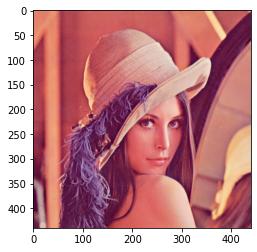

1. Thay đổi độ sáng cho ảnh


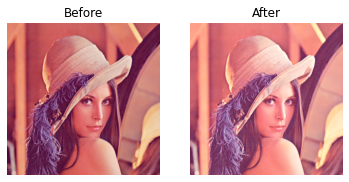

2. Thay đổi độ tương phản


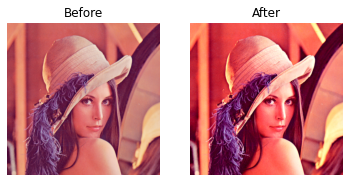

3. Lật ảnh (ngang - dọc)


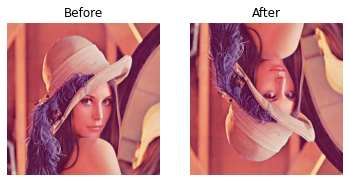

4. Chuyển đổi ảnh RGB thành ảnh xám/sepia


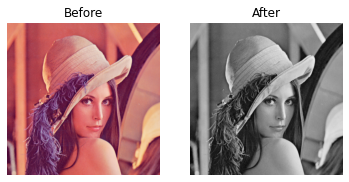

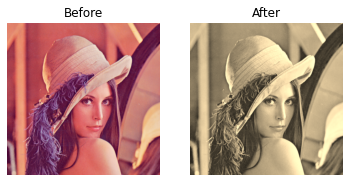

5. Làm mờ/sắc nét ảnh


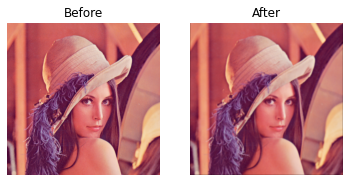

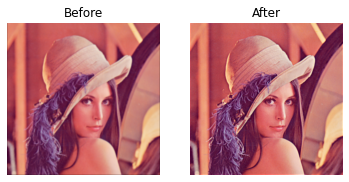

6. Cắt ảnh theo kích thước (cắt ở trung tâm)


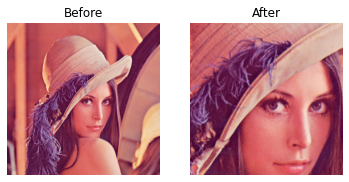

7. Cắt ảnh theo khung hình tròn


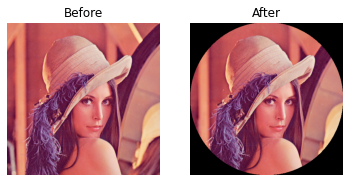

Thời gian thực hiện:  2.8648574352264404


In [468]:
if __name__ == "__main__":
    main()